In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, accuracy_score, balanced_accuracy_score
import os

In [83]:
### softmax

### dla wersji gdzie zapisujemy softmax
# dla wybranej osoby np. s29 bo ma ładne wyniki


pred_path = 'predictions/BENDR-polid-AASM-hpf05_emg/BENDR-polid-AASM-hpf05_emg' + '_s29.npy'
pred_softmax_path = 'predictions/BENDR-polid-AASM-hpf05_emg/BENDR-polid-AASM-hpf05_emg' + '_s29_softmax.npy'
 
# test_subject = os.listdir(pred_path)

# AASM
labels = ['REM', 'Stadium 3', 'Stadium 2', 'Stadium 1', 'Wake', 'Mięśnie']
classes = [0, 1, 2, 3, 4, 5]

# labels = ['REM', 'Stadium 4', 'Stadium 3', 'Stadium 2', 'Stadium 1', 'Wake', 'Mięśnie']
# classes = [0, 1, 2, 3, 4, 5, 6]
# ACC = 0
# BAC = 0
# MCC = 0

# conf_matrix = np.zeros((len(test_subjects)//2, len(labels), len(labels)))

in_and_out_labels = np.load(pred_path)
                     
y_true = in_and_out_labels[0]
y_BENDR = in_and_out_labels[1]
predictions_softmax = np.load(pred_softmax_path)

conf_matrix = confusion_matrix(y_true, y_BENDR, labels=classes, normalize='true') # true

MCC = matthews_corrcoef(y_true, y_BENDR)
ACC = accuracy_score(y_true, y_BENDR)
BAC = balanced_accuracy_score(y_true, y_BENDR)

print(accuracy_score(y_true, y_BENDR))
print(balanced_accuracy_score(y_true, y_BENDR))

0.815480844409695
0.7928802060895636


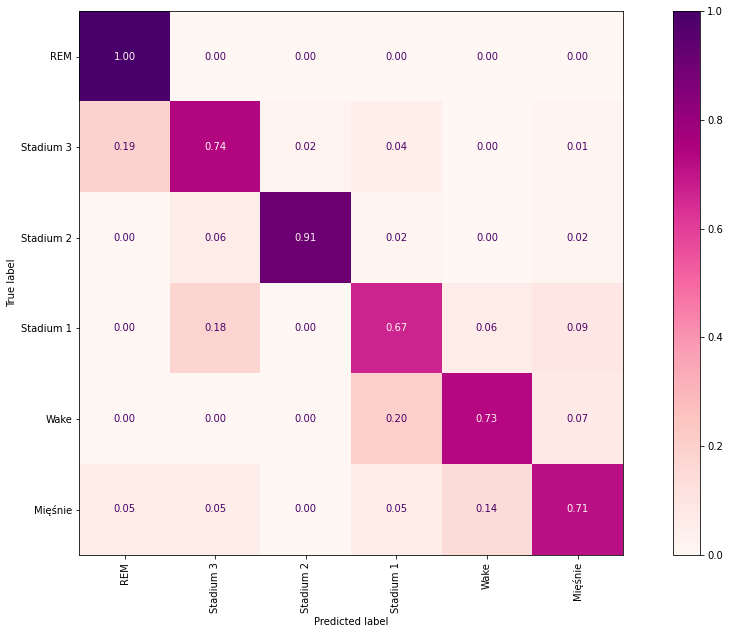

In [129]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels).plot(
    include_values=True, cmap=cmap, values_format=".2f")

plt.xticks(rotation=90)
plt.show()

In [132]:
# load examplatory signal

signal_path = '/dmj/fizmed/jjakubowska/dane-nowowiejska/edfs_AASM/dataset/test/s29/inb14.edf'
raw = mne.io.read_raw_edf(signal_path)

picks = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'A1', 'A2']  
raw_filtered = raw.copy().load_data()
raw_filtered.filter(l_freq=1, h_freq=None, picks = picks)
raw_filtered.filter(l_freq=10, h_freq=None, picks = ['EMG'])


#raw_highpass.set_montage("standard_1020")
# raw_highpass.plot(duration=20, start=20*ind, n_channels=len(raw.ch_names))

Extracting EDF parameters from /dmj/fizmed/jjakubowska/dane-nowowiejska/edfs_AASM/dataset/test/s29/inb14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3274751  =      0.000 ... 25583.992 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 10 Hz

<RawEDF | inb14.edf, 28 x 3274752 (25584.0 s), ~699.6 MB, data loaded>

In [134]:
# znajdz najwyższą predykcję z błędnych predykcji s3
    # znajdz najwyższą błędną predykcję
    # powinno być stadium 1, a predykacja na s3

def explore_best_predictions(raw1, y_true, y_BENDR, predictions_softmax, true=1, predicted=1):

    s3_false_positive_s1 = [i for i in range(len(y_true)) if (y_true[i]==true) and (y_BENDR[i]==predicted)]
    s3_preds_false_positive_s1 = np.max(predictions_softmax[s3_false_positive_s1], axis=1)
    s3_preds_false_positive_s1_max = np.argmax(predictions_softmax[s3_false_positive_s1, 1])
    ind_false_pred = s3_false_positive_s1[s3_preds_false_positive_s1_max]

    print(f'Maksymalna predykcja: {predictions_softmax[s3_false_positive_s1[s3_preds_false_positive_s1_max]]} dla ind = {predicted} przy przewidywaniu ind = {true}')

    raw1.plot(duration=20, start=20*ind_false_pred, n_channels=len(raw.ch_names))
    
    return ind_false_pred

Maksymalna predykcja: [8.9085056e-04 9.9731535e-01 1.2957726e-03 4.8643985e-04 6.1357075e-09
 1.1563296e-05] dla ind = 1 przy przewidywaniu ind = 3


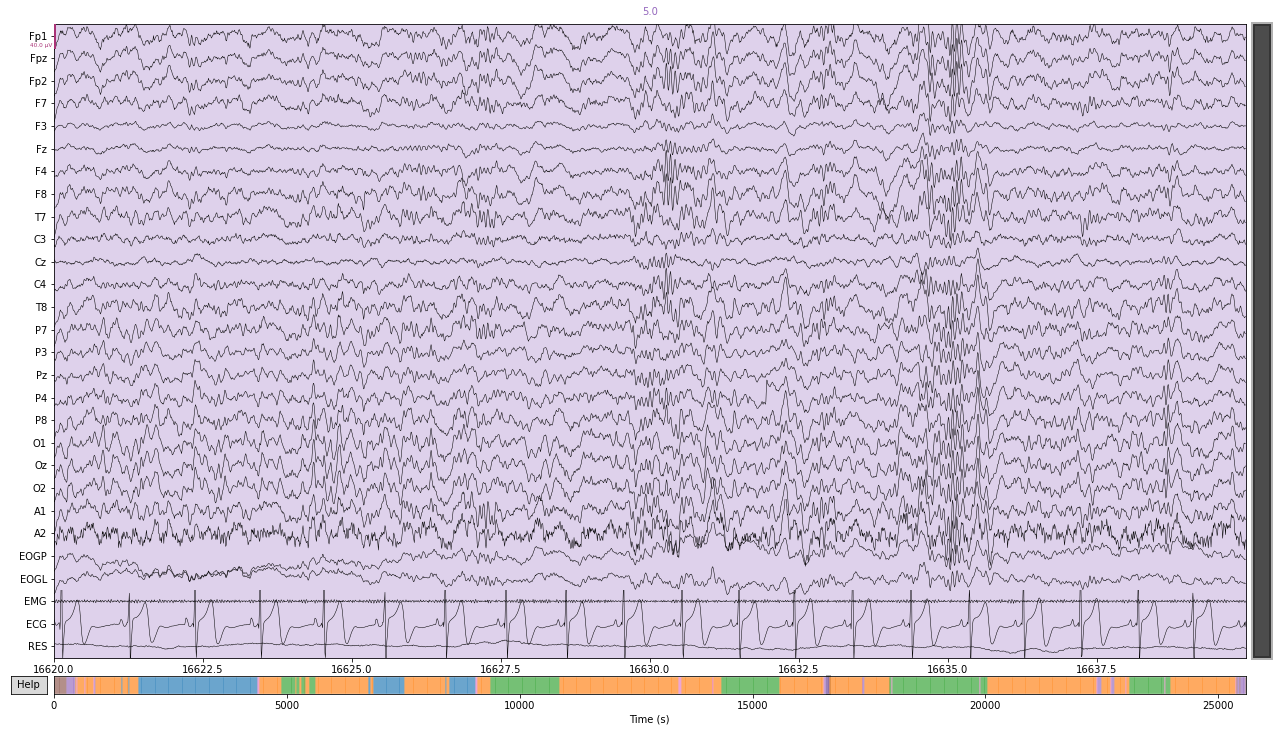

In [135]:
plt.rcParams["figure.figsize"] = [18,10]
max_ind = explore_best_predictions(raw_filtered, y_true, y_BENDR, predictions_softmax, true=3, predicted=1)

labels = ['REM', 'Stadium 3', 'Stadium 2', 'Stadium 1', 'Wake', 'Mięśnie']
classes = [0, 1, 2, 3, 4, 5]

In [136]:
# montaż

data = raw_filtered.get_data()
print(data.shape)

# 22, 21 to A1 i A2
A1 = data[21, :] * 10**6
A2 = data[22, :] * 10**6
print((A1+A2)/2)
print(data[0,:])
data -= (data[21, :] + data[22, :]) / 2

(28, 3274752)
[-1.69406589e-15  2.23827521e+01  3.72569078e+01 ... -9.78722336e-01
 -4.89698133e-01  5.30719081e-15]
[-5.92923063e-21  2.29210398e-05  3.93362581e-05 ... -8.29481863e-07
 -4.14792078e-07 -1.27054942e-21]


In [137]:
signal = raw_filtered.copy()

def f(arr, a1=A1, a2=A2):
    arr *= 10**6
    
    arr = arr - ((a1 + a2)/2)
    return arr / 10**6


picks = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']    

signal.apply_function(f, picks, channel_wise=True)


<RawEDF | inb14.edf, 28 x 3274752 (25584.0 s), ~699.6 MB, data loaded>

Maksymalna predykcja: [2.7274733e-04 3.5472989e-01 2.4229888e-02 6.2069255e-01 1.7423803e-05
 5.7578694e-05] dla ind = 3 przy przewidywaniu ind = 3


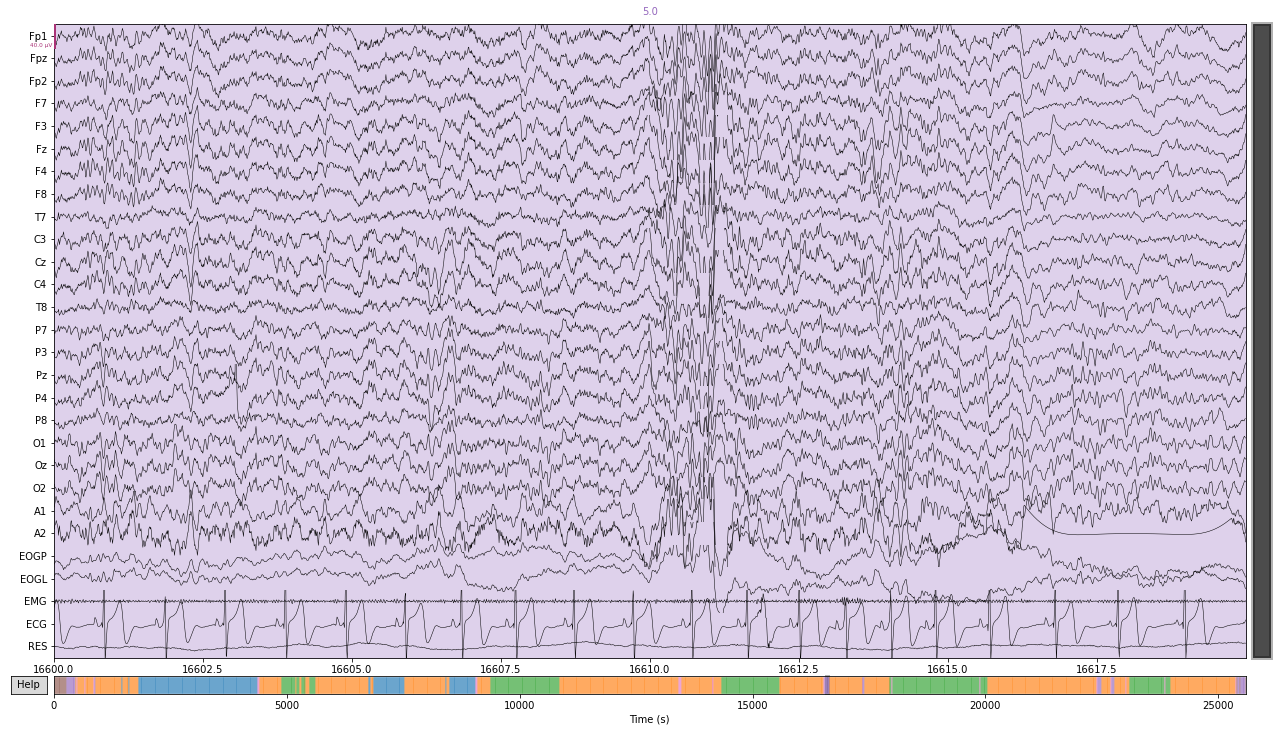

In [141]:
max_ind = explore_best_predictions(signal, y_true, y_BENDR, predictions_softmax, true=3, predicted=3)

1460


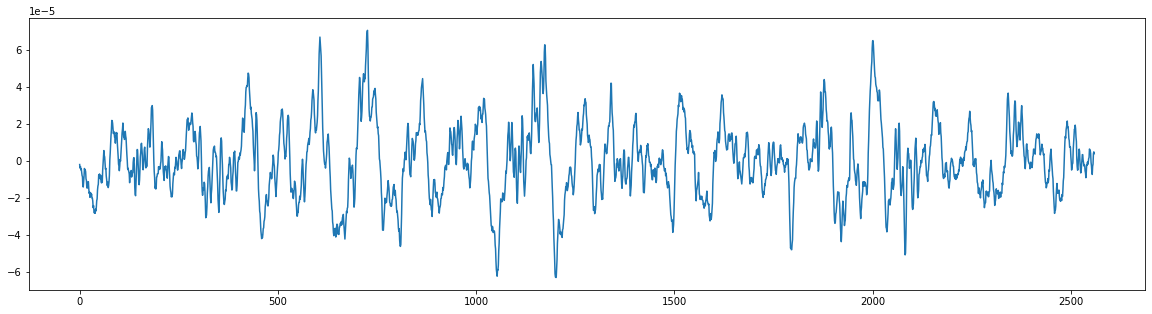

In [139]:
# widmo dla tego odcinka
# max_ind * f_samp, max_ind 

fs = 128
plt.figure(figsize=(20,5))
data = raw_filtered.get_data()

print(max_ind*20 + 20)
C4_cut = data[11, max_ind*20*fs : (max_ind*20 + 20)*fs]
plt.plot(C4_cut)

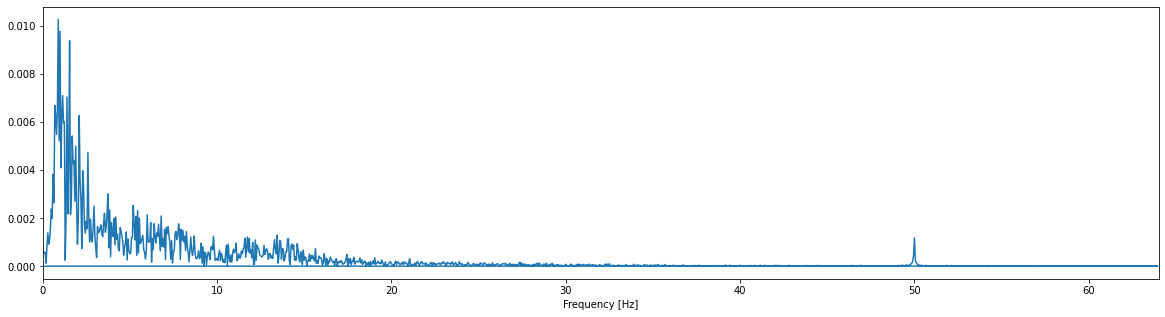

In [145]:
import numpy.fft as fft

plt.figure(figsize=(20,5))


Syg = fft.fft(C4_cut)
f = fft.fftfreq(len(C4_cut), 1/128) #os czestosci
widmo_amp = np.abs(Syg)
#print(f)
plt.plot(f, widmo_amp) #od 0 do 100 to czestosci ktore odpowiadaja dodatnik f, a pozozstale odpowiadaja ujemnym
# plt.stem(f,widmo_amp) 
plt.xlim([0,64])
plt.xlabel('Frequency [Hz]')
plt.show()

In [ ]:
# sprawdź najwyższe predykcje 